# Model Training - Sub model 2

## Load the Dataset 2

In [ ]:
import pandas as pd

PTB_EPTB = pd.read_csv(r'..\..\Datasets\train\balanced\PTB_EPTB.csv')

## Separate features and target

In [10]:
# Separate features and target in each dataset

X_PTB_EPTB = PTB_EPTB.drop(columns=['TB_Status'])
y_PTB_EPTB = PTB_EPTB['TB_Status']

## Training the model using best algorithm

In [11]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score



In [12]:
selected_features_path = r"..\..\Saved_files\selected_features_PTB_EPTB.csv"
model_save_path = r"..\..\Saved_files\best_sub_model_2.pkl"

# Load selected features
selected_features = pd.read_csv(selected_features_path)
selected_feature_names = selected_features['Selected Features'].tolist()
X_PTB_EPTB = X_PTB_EPTB[selected_feature_names]

# Split data
X_train_TB_Type, X_test_TB_Type, y_train_TB_Type, y_test_TB_Type = train_test_split(
    X_PTB_EPTB, y_PTB_EPTB, test_size=0.2, random_state=42
)

# Feature selection using Extra Trees Classifier
feature_selector = SelectFromModel(ExtraTreesClassifier(random_state=42), threshold="mean")
X_train_selected = feature_selector.fit_transform(X_train_TB_Type, y_train_TB_Type)
X_test_selected = feature_selector.transform(X_test_TB_Type)

# ✅ Get selected feature names
selected_mask = feature_selector.get_support()
selected_feature_names_final = np.array(selected_feature_names)[selected_mask]

# Display selected feature information
print("\n" + "="*60)
print("🔍 FEATURE SELECTION RESULTS (Extra Trees Classifier - Sub Model 2)")
print("="*60)
print(f"Total features before selection : {len(selected_feature_names)}")
print(f"Total features after selection  : {len(selected_feature_names_final)}\n")
print("Selected Features:")
for i, feature in enumerate(selected_feature_names_final, start=1):
    print(f"{i}. {feature}")
print("="*60 + "\n")

# Save feature selector
feature_selector_TB_Type_path = r"..\..\Saved_files\feature_selector_TB_Type.pkl"
with open(feature_selector_TB_Type_path, 'wb') as file:
    pickle.dump(feature_selector, file)

# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_TB_Type)
y_test_encoded = label_encoder.transform(y_test_TB_Type)

# Save label encoder
label_encoder_TB_Type_path = r"..\..\Saved_files\label_encoder_TB_Type.pkl"
with open(label_encoder_TB_Type_path, 'wb') as file:
    pickle.dump(label_encoder, file)

# Define TB type labels
tb_type_labels = ["Pulmonary TB", "Extra Pulmonary TB"]

print(f"Training set shape: {X_train_selected.shape}")
print(f"Test set shape: {X_test_selected.shape}")
print(f"Class distribution in training: {dict(zip(tb_type_labels, np.bincount(y_train_encoded)))}")



🔍 FEATURE SELECTION RESULTS (Extra Trees Classifier - Sub Model 2)
Total features before selection : 45
Total features after selection  : 17

Selected Features:
1. ILMN_2079655
2. ILMN_1710734
3. ILMN_1658399
4. ILMN_1680772
5. ILMN_1778625
6. ILMN_2390453
7. ILMN_1685441
8. ILMN_1797193
9. ILMN_1773966
10. ILMN_2134555
11. ILMN_1679092
12. ILMN_1787461
13. ILMN_2131022
14. ILMN_1855230
15. ILMN_1728676
16. ILMN_1685122
17. ILMN_1814247

Training set shape: (337, 17)
Test set shape: (85, 17)
Class distribution in training: {'Pulmonary TB': 169, 'Extra Pulmonary TB': 168}


In [13]:
# --- Create Optimized Random Forest Pipeline (Sub-Model 2: TB_Type) ---
best_model_TB_Type = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        random_state=42,
        n_estimators=100,          # Initial number of trees
        max_depth=30,              # Allow deeper trees for complex patterns
        min_samples_split=5,       # Prevent overfitting
        min_samples_leaf=2,
        max_features='sqrt',
        oob_score=True,            # Enable OOB score for early stopping
        warm_start=True,           # Allow incremental training
        n_jobs=-1
    )
)

# --- Cross-validation for model robustness ---
cv_scores = cross_val_score(
    best_model_TB_Type, X_train_selected, y_train_encoded, cv=5, scoring='f1_weighted', n_jobs=-1
)
print("Cross-validation F1 scores:", cv_scores)
print("Mean CV F1 Score:", np.mean(cv_scores))

# --- Early Stopping based on OOB Score ---
print("\nPerforming incremental training with early stopping based on OOB score...\n")
prev_oob_score = 0
best_n_estimators = 100

for i in range(10):  # Incrementally increase trees
    best_model_TB_Type.named_steps['randomforestclassifier'].n_estimators += 25
    best_model_TB_Type.fit(X_train_selected, y_train_encoded)
    curr_oob_score = best_model_TB_Type.named_steps['randomforestclassifier'].oob_score_
    print(f"Iteration {i+1}: n_estimators = {best_model_TB_Type.named_steps['randomforestclassifier'].n_estimators}, OOB Score = {curr_oob_score:.4f}")
    
    if curr_oob_score <= prev_oob_score:  # Stop when no improvement
        best_model_TB_Type.named_steps['randomforestclassifier'].n_estimators = best_n_estimators
        print("\nEarly stopping triggered — OOB score stopped improving.")
        break
    prev_oob_score = curr_oob_score
    best_n_estimators = best_model_TB_Type.named_steps['randomforestclassifier'].n_estimators

# --- Evaluate on Test Set ---
y_pred_best_TB_Type = best_model_TB_Type.predict(X_test_selected)
y_pred_proba = best_model_TB_Type.named_steps['randomforestclassifier'].predict_proba(X_test_selected)

print("\n" + "="*60)
print("SUB-MODEL 2 (PTB_EPTB) - OPTIMIZED RANDOM FOREST PERFORMANCE")
print("="*60)

# --- Detailed classification report ---
print("\nBest TB_Type Classification Report:")
print(classification_report(y_test_encoded, y_pred_best_TB_Type, target_names=tb_type_labels))

# --- Overall metrics ---
accuracy = accuracy_score(y_test_encoded, y_pred_best_TB_Type)
precision = precision_score(y_test_encoded, y_pred_best_TB_Type, average='weighted')
recall = recall_score(y_test_encoded, y_pred_best_TB_Type, average='weighted')
f1 = f1_score(y_test_encoded, y_pred_best_TB_Type, average='weighted')

print(f"\nOverall Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# --- Class-wise metrics ---
print(f"\nClass-wise Performance:")
for i, label in enumerate(tb_type_labels):
    class_precision = precision_score(y_test_encoded, y_pred_best_TB_Type, average=None)[i]
    class_recall = recall_score(y_test_encoded, y_pred_best_TB_Type, average=None)[i]
    class_f1 = f1_score(y_test_encoded, y_pred_best_TB_Type, average=None)[i]
    print(f"{label:20} - Precision: {class_precision:.4f}, Recall: {class_recall:.4f}, F1: {class_f1:.4f}")

# --- Save the Trained Model ---
model_save_path = r"..\..\Saved_files\best_sub_model_2.pkl"
with open(model_save_path, 'wb') as file:
    pickle.dump(best_model_TB_Type, file)

print(f"\n✅ Trained model saved to {model_save_path}")


Cross-validation F1 scores: [0.76450216 0.79393939 0.75958915 0.68642739 0.79076493]
Mean CV F1 Score: 0.7590446059264747

Performing incremental training with early stopping based on OOB score...

Iteration 1: n_estimators = 125, OOB Score = 0.7448
Iteration 2: n_estimators = 150, OOB Score = 0.7626
Iteration 3: n_estimators = 175, OOB Score = 0.7626

Early stopping triggered — OOB score stopped improving.

SUB-MODEL 2 (PTB_EPTB) - OPTIMIZED RANDOM FOREST PERFORMANCE

Best TB_Type Classification Report:
                    precision    recall  f1-score   support

      Pulmonary TB       0.81      0.81      0.81        42
Extra Pulmonary TB       0.81      0.81      0.81        43

          accuracy                           0.81        85
         macro avg       0.81      0.81      0.81        85
      weighted avg       0.81      0.81      0.81        85


Overall Metrics:
Accuracy:  0.8118
Precision: 0.8118
Recall:    0.8118
F1-Score:  0.8118

Class-wise Performance:
Pulmonary TB

In [14]:
# Extract the scaler correctly
scaler_TB_Type = best_model_TB_Type.named_steps['standardscaler']  # Use 'standardscaler' instead of 'scaler'

# Define path to save the scaler
scaler_save_path_TB_Type = r"..\..\Saved_files\scalar\scaler_TB_Type.pkl"

# Save the scaler
with open(scaler_save_path_TB_Type, 'wb') as file:
    pickle.dump(scaler_TB_Type, file)

print(f"Scaler for TB Type saved to {scaler_save_path_TB_Type}")


Scaler for TB Type saved to ..\..\Saved_files\scalar\scaler_TB_Type.pkl


## Evaluation of the sub model

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate the model and display metrics
def evaluate_model(y_true, y_pred, label):
    print(f"\n--- Evaluation Metrics for {label} ---")
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\n")

    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


--- Model Evaluation ---

--- Evaluation Metrics for TB_Type ---
Accuracy: 0.81
Precision: 0.81
Recall: 0.81
F1 Score: 0.81




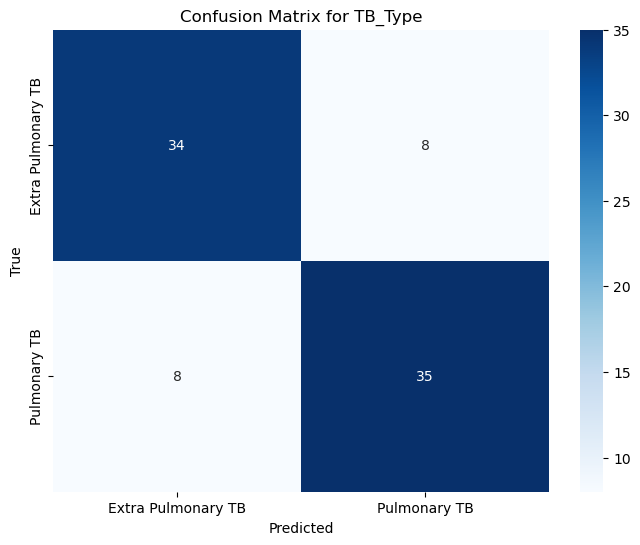

In [16]:
# Evaluate model using test datasets
print("\n--- Model Evaluation ---")
# TB_Type Evaluation using the best model
y_pred_TB_Type = best_model_TB_Type.predict(X_test_selected)

# Convert encoded predictions back to text labels
y_test_labels = label_encoder.inverse_transform(y_test_encoded)
y_pred_labels = label_encoder.inverse_transform(y_pred_TB_Type)

# Evaluate using original labels
evaluate_model(y_test_labels, y_pred_labels, "TB_Type")

